In [1]:
%matplotlib widget

In [2]:
from pymongo import MongoClient
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress
from scipy import stats
import holoviews as hv

In [3]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [4]:
print(mongo.list_database_names())

['admin', 'autosaurus', 'classDB', 'config', 'local', 'met', 'migration_population', 'petsitly_marketing', 'uk_food']


In [5]:
# assign the uk_food database to a variable name
db = mongo['migration_population']

In [6]:
# List the names of the collections in the database.
# Be sure to use the variable name you assigned to your database to do this.
print(db.list_collection_names())

['top10countries']


In [7]:
# review the collections in our database
print("Collections in 'migration_population':", db.list_collection_names())

Collections in 'migration_population': ['top10countries']


In [8]:
top10countries=db['top10countries']

In [9]:
# review a document in the customer_list collection
pprint(db.top10countries.find_one())  

{'_id': ObjectId('678c0ca544595cfdd3dac696'),
 'capitalCity': 'Dhaka',
 'country': 'Bangladesh',
 'incomeLevel': 'Lower middle income',
 'latitude': 23.7055,
 'lendingType': 'IDA',
 'longitude': 90.4113,
 'migration_perc': -0.0115707154666858,
 'net_migration': -1847503.0,
 'pop_density': 1226.63127448721,
 'population': 159670593.0,
 'region': 'South Asia',
 'year': 2017}


In [10]:
# Create a query that:
# finds countries with a year in the list, ["top10countries"]
# sorts in descending order by year, then ascending order by countries
# limits the results to the first 25
query = {'country': {'$in': ['India', 'Mexico', 'Russian Federation', 'China', 'Bangladesh', 'Pakistan', 'Ukraine', 'Philippines', 'Poland', 'United Kingdom']}}
sort = [('population', -1), ('year', 1)]
limit = 25

# Pretty print the results
pprint(list(top10countries.find(query).sort(sort).limit(limit)))

[{'_id': ObjectId('678c0ca544595cfdd3dac6a2'),
  'capitalCity': 'Beijing',
  'country': 'China',
  'incomeLevel': 'Upper middle income',
  'latitude': 40.0495,
  'lendingType': 'IBRD',
  'longitude': 116.286,
  'migration_perc': -0.0012564932793323,
  'net_migration': -1741996.0,
  'pop_density': 147.674050750889,
  'population': 1386395000.0,
  'region': 'East Asia & Pacific',
  'year': 2017},
 {'_id': ObjectId('678c0ca544595cfdd3dac6a3'),
  'capitalCity': 'Beijing',
  'country': 'China',
  'incomeLevel': 'Upper middle income',
  'latitude': 40.0495,
  'lendingType': 'IBRD',
  'longitude': 116.286,
  'migration_perc': -0.0011491928229541,
  'net_migration': -1552209.0,
  'pop_density': 143.871389770868,
  'population': 1350695000.0,
  'region': 'East Asia & Pacific',
  'year': 2012},
 {'_id': ObjectId('678c0ca544595cfdd3dac6ae'),
  'capitalCity': 'New Delhi',
  'country': 'India',
  'incomeLevel': 'Lower middle income',
  'latitude': 28.6353,
  'lendingType': 'IBRD',
  'longitude': 77

In [11]:
# Create a query that finds the countries who have a India
query = {'country': "India"}

# Print the number of results
print("Number of documents in result:", top10countries.count_documents(query)) 

Number of documents in result: 12


In [12]:
# Display the number of documents in the top10countries collection for records 
top10countries.count_documents({})

120

A negative net migration rate means that more people are moving out of an area than are moving into it. 

In [13]:
# Query to count documents where 'net_migration' starts with '-'
count = top10countries.count_documents({
    "net_migration": {"$lt": 0}
})

print(f"Number of documents where 'net_migration' starts with '-': {count}")

Number of documents where 'net_migration' starts with '-': 83


In [14]:
# Write an aggregation query that counts the number of documents, grouped by "country"
query = [{'$group': {'_id': "$country", 'count': { '$sum': 1 }}}]

In [15]:
# Run the query with the aggregate method and save the results to a variable
results = list(top10countries.aggregate(query))

In [16]:
# Print the number of countries in the result
print("Number of countries in result: ", len(results))

Number of countries in result:  10


In [17]:

pprint(results)

[{'_id': 'Ukraine', 'count': 12},
 {'_id': 'United Kingdom', 'count': 12},
 {'_id': 'Bangladesh', 'count': 12},
 {'_id': 'Pakistan', 'count': 12},
 {'_id': 'Mexico', 'count': 12},
 {'_id': 'India', 'count': 12},
 {'_id': 'Philippines', 'count': 12},
 {'_id': 'China', 'count': 12},
 {'_id': 'Poland', 'count': 12},
 {'_id': 'Russian Federation', 'count': 12}]


In [18]:
# Convert mongo result to Pandas DataFrame
result_df = pd.DataFrame(results)

print("Rows in DataFrame: ", len(result_df))
result_df.head(10)

Rows in DataFrame:  10


,_id,count
0,Ukraine,12
1,United Kingdom,12
2,Bangladesh,12
3,Pakistan,12
4,Mexico,12
5,India,12
6,Philippines,12
7,China,12
8,Poland,12
9,Russian Federation,12


In [19]:
# Build the aggregation pipeline

# Write an aggregation query that counts the number of documents, grouped by "Country", then "migration_perc", "population","year", "net_migration" 
group_query = {'$group': {'_id': {"country": "$country",
                                  "migration_perc": "$migration_perc",
                                 "population" : "$population",
                                 "year" : "$year",
                                 "net_migration" : "$net_migration"}, 
                          'count': { '$sum': 1 }
                         }
              }

# Create a match query that matches only the rows that have 0 or more documents in 'count'
match_query = {'$match': {'count': {'$gte': 0}}}

# Create a dictionary that will allow the pipeline to sort by country in alphabetical order, 
# then count in descending order
sort_values = {'$sort': { '_id.country': 1, 'count': -1 }}

# Put the pipeline together
pipeline = [group_query, match_query, sort_values]

In [20]:
# Run the pipeline through the aggregate method, cast the results as a list, and save the results to a variable
results = list(top10countries.aggregate(pipeline))
# Print the number of rows in the result
print("Number of rows in result: ", len(results))

Number of rows in result:  120


In [21]:
 # Print the results
pprint(results)

[{'_id': {'country': 'Bangladesh',
          'migration_perc': -0.0228148704725129,
          'net_migration': -3254778.0,
          'population': 142660376.0,
          'year': 2007},
  'count': 1},
 {'_id': {'country': 'Bangladesh',
          'migration_perc': -0.0152762896556732,
          'net_migration': -2306839.0,
          'population': 151007807.0,
          'year': 2012},
  'count': 1},
 {'_id': {'country': 'Bangladesh',
          'migration_perc': -0.0115707154666858,
          'net_migration': -1847503.0,
          'population': 159670593.0,
          'year': 2017},
  'count': 1},
 {'_id': {'country': 'Bangladesh',
          'migration_perc': -0.0154817385440928,
          'net_migration': -1137344.0,
          'population': 73463584.0,
          'year': 1977},
  'count': 1},
 {'_id': {'country': 'Bangladesh',
          'migration_perc': -0.0112662935060822,
          'net_migration': -1492537.0,
          'population': 132478086.0,
          'year': 2002},
  'count': 1},
 

In [22]:
# Extract the fields from the _id so they're in separate columns in a Pandas DataFrame
aggregated_df = pd.json_normalize(results)
aggregated_df

,count,_id.country,_id.migration_perc,_id.population,_id.year,_id.net_migration
0,1,Bangladesh,-0.022815,142660376.0,2007,-3254778.0
1,1,Bangladesh,-0.015276,151007807.0,2012,-2306839.0
2,1,Bangladesh,-0.011571,159670593.0,2017,-1847503.0
3,1,Bangladesh,-0.015482,73463584.0,1977,-1137344.0
4,1,Bangladesh,-0.011266,132478086.0,2002,-1492537.0
...,...,...,...,...,...,...
115,1,United Kingdom,0.008803,58316954.0,1997,513361.0
116,1,United Kingdom,0.001897,56086065.0,1972,106415.0
117,1,United Kingdom,0.020412,63700300.0,2012,1300231.0
118,1,United Kingdom,0.002687,53250000.0,1962,143068.0


In [23]:
 # Rename the columns
aggregated_df = aggregated_df.rename(columns={"count": "count of country",
                                              "_id.country": "country",
                                             "_id.migration_perc" : "migration_perc",
                                             "_id.population" : "population",
                                             "_id.year" : "year",
                                             "_id.net_migration" : "net_migration"})
aggregated_df

,count of country,country,migration_perc,population,year,net_migration
0,1,Bangladesh,-0.022815,142660376.0,2007,-3254778.0
1,1,Bangladesh,-0.015276,151007807.0,2012,-2306839.0
2,1,Bangladesh,-0.011571,159670593.0,2017,-1847503.0
3,1,Bangladesh,-0.015482,73463584.0,1977,-1137344.0
4,1,Bangladesh,-0.011266,132478086.0,2002,-1492537.0
...,...,...,...,...,...,...
115,1,United Kingdom,0.008803,58316954.0,1997,513361.0
116,1,United Kingdom,0.001897,56086065.0,1972,106415.0
117,1,United Kingdom,0.020412,63700300.0,2012,1300231.0
118,1,United Kingdom,0.002687,53250000.0,1962,143068.0


In [24]:
# Reorder the columns
aggregated_df = aggregated_df[["country", "year", "net_migration", "population", "migration_perc",  "count of country"]]

# Print the first 10 rows of the DataFrame
aggregated_df

,country,year,net_migration,population,migration_perc,count of country
0,Bangladesh,2007,-3254778.0,142660376.0,-0.022815,1
1,Bangladesh,2012,-2306839.0,151007807.0,-0.015276,1
2,Bangladesh,2017,-1847503.0,159670593.0,-0.011571,1
3,Bangladesh,1977,-1137344.0,73463584.0,-0.015482,1
4,Bangladesh,2002,-1492537.0,132478086.0,-0.011266,1
...,...,...,...,...,...,...
115,United Kingdom,1997,513361.0,58316954.0,0.008803,1
116,United Kingdom,1972,106415.0,56086065.0,0.001897,1
117,United Kingdom,2012,1300231.0,63700300.0,0.020412,1
118,United Kingdom,1962,143068.0,53250000.0,0.002687,1


In [25]:
 # Print out the unique countries
aggregated_df["country"].unique()

array(['Bangladesh', 'China', 'India', 'Mexico', 'Pakistan',
       'Philippines', 'Poland', 'Russian Federation', 'Ukraine',
       'United Kingdom'], dtype=object)

In [26]:
# Print out the unique classifications
aggregated_df["migration_perc"].unique()

array([-2.28148705e-02, -1.52762897e-02, -1.15707155e-02, -1.54817385e-02,
       -1.12662935e-02, -5.99114199e-03, -7.53626677e-03, -2.74115455e-03,
       -4.57073888e-02, -9.45795166e-03, -2.80535860e-03, -2.29288527e-03,
       -4.98211361e-05, -2.12049566e-04, -1.14919282e-03, -1.53512808e-03,
       -1.28241361e-03, -3.98189173e-04, -1.25649328e-03, -1.98288768e-04,
       -6.69529687e-04, -1.65294013e-03, -3.11362315e-04, -1.69086471e-03,
        3.62431111e-03, -1.85661791e-03,  7.91691785e-04, -1.98962867e-03,
       -2.24461016e-03, -1.72775661e-03, -1.82040401e-04,  1.70328181e-03,
        5.50823300e-05, -6.08098244e-04, -6.81955220e-04, -6.58811723e-04,
       -2.31759485e-02, -5.15161138e-03, -1.31204164e-02, -1.99430402e-02,
       -2.16956213e-02, -2.40428301e-03, -2.42727585e-02, -3.60247320e-03,
       -1.01774289e-02, -1.68290539e-02, -1.79175643e-02, -2.31815079e-02,
       -3.91342675e-03, -2.02496179e-03,  1.66258098e-02, -4.34759816e-03,
        3.59314994e-03, -

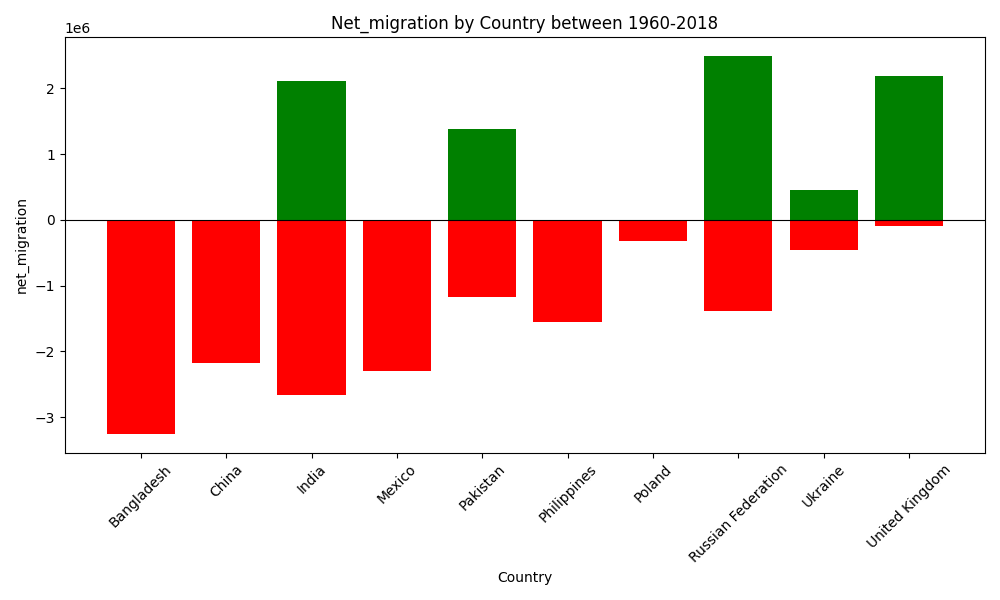

In [27]:


fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if value >= 0 else 'red' for value in aggregated_df['net_migration']]
ax.bar(
    aggregated_df['country'],
    aggregated_df['net_migration'],
    color=colors
)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Net_migration by Country between 1960-2018")
plt.ylabel("net_migration")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
plt.savefig("../Images/net_migration_by_country_bar_charts.png", format="png")

In [29]:
# Calculate the correlation between population and migration percentage
correlation_net_migration_population = aggregated_df['net_migration'].corr(aggregated_df['population'])

correlation_net_migration_population

-0.31216009411645557

The correlation between net migration and populaton is approximately -0.3121, r < 0: Negative correlation (as one variable increases, the other tends to decrease).
A slight tendency exists where countries with higher populations have lower net migration. Countries with large populations might experience less net migration relative to smaller countries. However, this relationship is weak, so it's not a consistent trend.

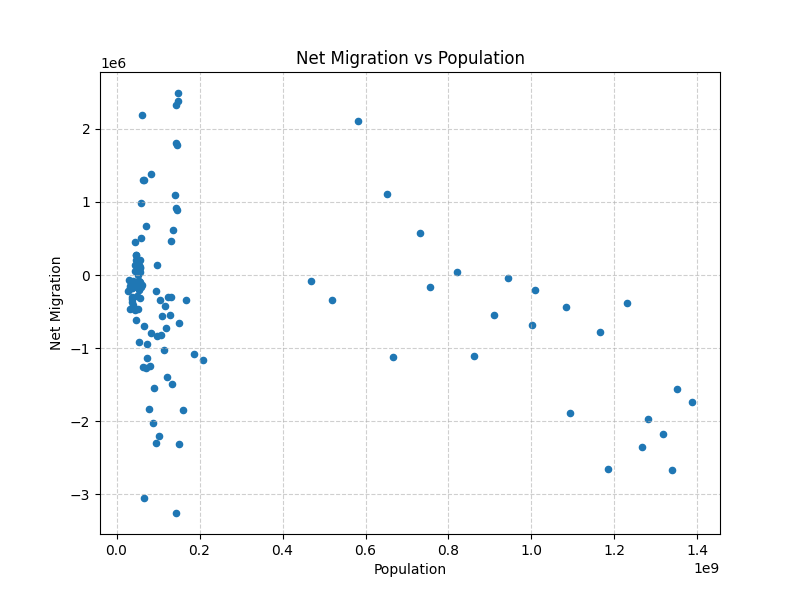

In [30]:
aggregated_df.plot(
    kind="scatter",
    x="population",
    y="net_migration",
    title="Net Migration vs Population",
    figsize=(8, 6)
)
plt.xlabel("Population")
plt.ylabel("Net Migration")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [31]:
plt.savefig("../Images/net_migration_population_scatter_plot.png", format="png")

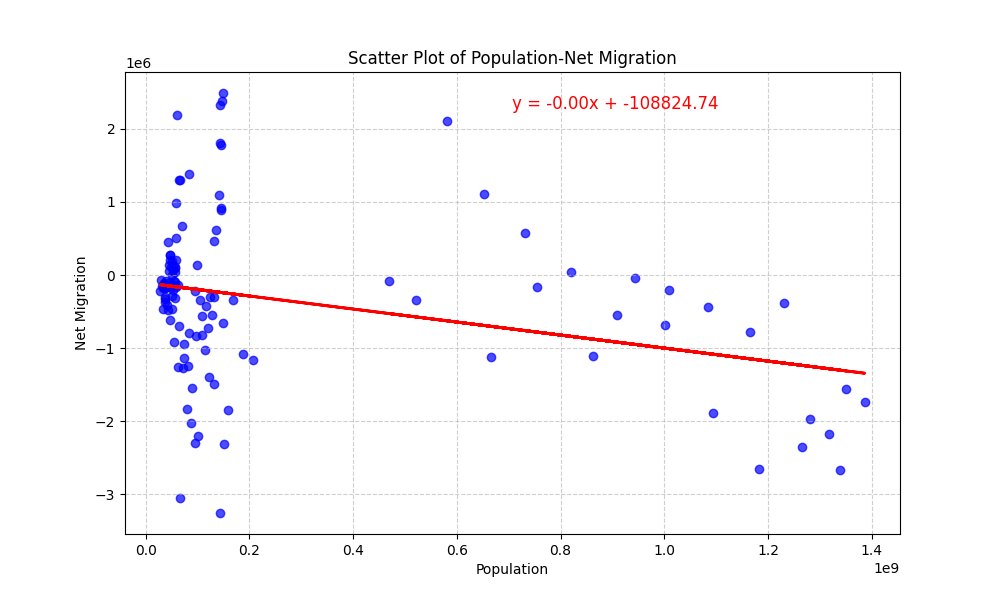

-0.000890306226708056 -108824.74168140124 -0.3121600941164556 0.0005187104974457907 0.0002494354185895195


In [32]:
# Perform linear regression to get the line equation
slope, intercept, r_value, p_value, std_err = linregress(
    aggregated_df['population'], aggregated_df['net_migration']
)

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(aggregated_df['population'], aggregated_df['net_migration'], alpha=0.7, color='blue')
plt.plot(aggregated_df['population'], slope * aggregated_df['population'] + intercept, color='red', linewidth=2)

# Add labels and title
plt.title("Scatter Plot of Population-Net Migration")
plt.xlabel("Population")
plt.ylabel("Net Migration")

# Display the line equation on the plot
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.text(0.5, 0.95, line_eq, transform=plt.gca().transAxes, color="red", fontsize=12, verticalalignment="top")

# Show plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(slope, intercept, r_value, p_value, std_err) 

In [33]:
plt.savefig("../Images/net_migration_population_scatter_plot_line_equation.png", format="png")

In [34]:
query = {'year' : 2017 ,
    'country': {'$in': ['India', 'Mexico', 'Russian Federation', 'China', 'Bangladesh', 'Pakistan', 'Ukraine', 'Philippines', 'Poland', 'United Kingdom']}}
sort = [('population', -1), ('year', 1)]
limit = 25

# Pretty print the results
pprint(list(top10countries.find(query).sort(sort).limit(limit)))

[{'_id': ObjectId('678c0ca544595cfdd3dac6a2'),
  'capitalCity': 'Beijing',
  'country': 'China',
  'incomeLevel': 'Upper middle income',
  'latitude': 40.0495,
  'lendingType': 'IBRD',
  'longitude': 116.286,
  'migration_perc': -0.0012564932793323,
  'net_migration': -1741996.0,
  'pop_density': 147.674050750889,
  'population': 1386395000.0,
  'region': 'East Asia & Pacific',
  'year': 2017},
 {'_id': ObjectId('678c0ca544595cfdd3dac6ae'),
  'capitalCity': 'New Delhi',
  'country': 'India',
  'incomeLevel': 'Lower middle income',
  'latitude': 28.6353,
  'lendingType': 'IBRD',
  'longitude': 77.225,
  'migration_perc': -0.0019896286718938,
  'net_migration': -2663434.0,
  'pop_density': 450.243285831043,
  'population': 1338658835.0,
  'region': 'South Asia',
  'year': 2017},
 {'_id': ObjectId('678c0ca544595cfdd3dac6c6'),
  'capitalCity': 'Islamabad',
  'country': 'Pakistan',
  'incomeLevel': 'Lower middle income',
  'latitude': 30.5167,
  'lendingType': 'Blend',
  'longitude': 72.8,


In [35]:
# Query to filter records where year is 2017 or specific year
query = {"year": 2017}

# Fetch the data
data = list(top10countries.find(query))
df=pd.DataFrame(data)
df



,_id,country,year,population,pop_density,net_migration,migration_perc,region,incomeLevel,lendingType,capitalCity,longitude,latitude
0,678c0ca544595cfdd3dac696,Bangladesh,2017,1.596706e+08,1226.631274,-1847503.0,-0.011571,South Asia,Lower middle income,IDA,Dhaka,90.411300,23.7055
1,678c0ca544595cfdd3dac6a2,China,2017,1.386395e+09,147.674051,-1741996.0,-0.001256,East Asia & Pacific,Upper middle income,IBRD,Beijing,116.286000,40.0495
2,678c0ca544595cfdd3dac6ae,India,2017,1.338659e+09,450.243286,-2663434.0,-0.001990,South Asia,Lower middle income,IBRD,New Delhi,77.225000,28.6353
3,678c0ca544595cfdd3dac6ba,Mexico,2017,1.247773e+08,64.187517,-300000.0,-0.002404,Latin America & Caribbean,Upper middle income,IBRD,Mexico City,-99.127600,19.4270
4,678c0ca544595cfdd3dac6c6,Pakistan,2017,2.078967e+08,269.687482,-1166895.0,-0.005613,South Asia,Lower middle income,Blend,Islamabad,72.800000,30.5167
5,678c0ca544595cfdd3dac6d2,Philippines,2017,1.051733e+08,352.729195,-335758.0,-0.003192,East Asia & Pacific,Lower middle income,IBRD,Manila,121.035000,14.5515
6,678c0ca544595cfdd3dac6de,Poland,2017,3.797483e+07,124.023730,-146976.0,-0.003870,Europe & Central Asia,High income,IBRD,Warsaw,21.020000,52.2600
7,678c0ca544595cfdd3dac6ea,Russian Federation,2017,1.444967e+08,8.823221,912279.0,0.006313,Europe & Central Asia,Upper middle income,IBRD,Moscow,37.617600,55.7558
8,678c0ca544595cfdd3dac6f6,Ukraine,2017,4.483114e+07,77.389796,50001.0,0.001115,Europe & Central Asia,Lower middle income,IBRD,Kiev,30.503800,50.4536
9,678c0ca544595cfdd3dac702,United Kingdom,2017,6.605886e+07,273.049473,1303250.0,0.019729,Europe & Central Asia,High income,Not classified,London,-0.126236,51.5002


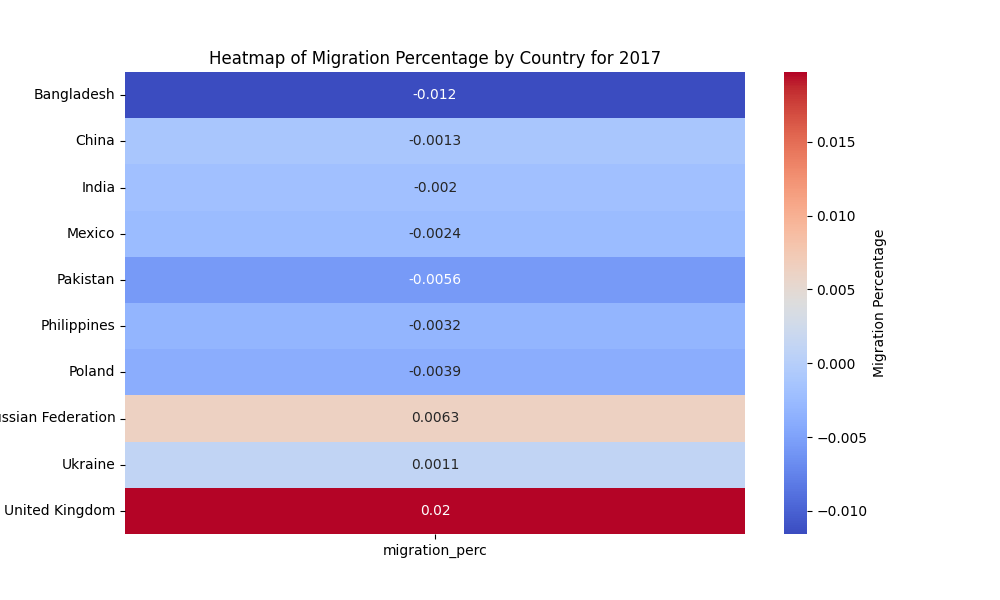

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
   df.set_index('country')[['migration_perc']], 
    annot=True, 
    cmap='coolwarm', 
    cbar_kws={'label': 'Migration Percentage'}
)
plt.title("Heatmap of Migration Percentage by Country for 2017")
plt.show()


In [37]:
plt.savefig("../Images/Heatmap_of_Migration_Percentage_by_Country_for_2017.png", format="png")

The United Kingdom has the highest positive migration percentage (0.02), indicating a significant net inflow of migrants relative to its population that the UK was an attractive destination for migrants in 2017.

Bangladesh shows the largest negative migration percentage (-0.012), indicating a high net outflow of migrants, likely due to economic, social, or environmental factors.



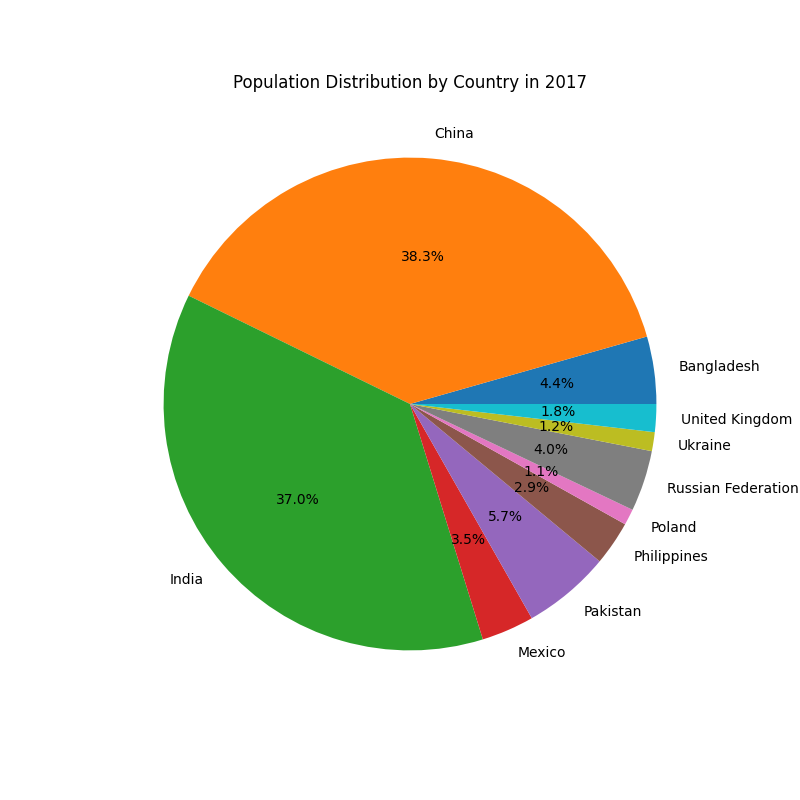

In [38]:
import matplotlib.pyplot as plt

# Pie chart for population distribution
df.plot(
    kind="pie",
    y="population",
    autopct='%1.1f%%',
    labels=df["country"],
    legend=False,
    title="Population Distribution by Country in 2017",
    figsize=(8, 8)
)

plt.ylabel("")  # Remove the default y-axis label
plt.show()


In [39]:
plt.savefig("../Images/Population_Distribution_by_Country_in_2017.png", format="png")